# Smoke Detection
Use Transfer Learning to detect smoke in an image

In [15]:
from preprocess_img import get_preprocessed_img, resize_img
from train import train
from evaluation import get_evaluation
from detect_smoke import detect_smoke
from keras.models import load_model
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np

%matplotlib inline

## Load the image dataset

In [4]:
!ls /QrrgfoqzLJGN7voPLSURUf

1  2  3  4  5


### Set the dataset path

In [5]:
dataset_path = '/QrrgfoqzLJGN7voPLSURUf/1'

### Get the image

In [6]:
smoke_img, nonsmoke_img = get_preprocessed_img(dataset_path)

### Get an image for check

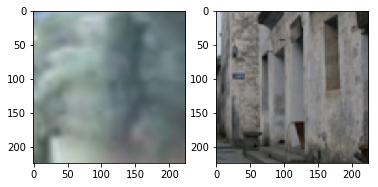

In [7]:
plt.figure
plt.subplot(121)
plt.imshow(smoke_img[0])
plt.subplot(122)
plt.imshow(nonsmoke_img[0])

In [8]:
print("smoke image shape: {}".format(smoke_img.shape))
print("non smoke image shape: {}".format(nonsmoke_img.shape))

smoke image shape: (552, 224, 224, 3)
non smoke image shape: (831, 224, 224, 3)


### Generate labels
**1** for **smoke image** and **0** for **non smoke image**

In [9]:
smoke_labels = np.ones(smoke_img.shape[0], dtype=np.int8)
nonsmoke_labels = np.zeros(nonsmoke_img.shape[0], dtype=np.int8)

### Split the dataset to train, validation sets

In [10]:
smoke_pos = int(smoke_img.shape[0] * 0.8)
nonsmoke_pos = int(nonsmoke_img.shape[0] * 0.8)

X_train = np.concatenate((smoke_img[:smoke_pos], nonsmoke_img[:nonsmoke_pos]))
y_train = np.concatenate((smoke_labels[:smoke_pos], nonsmoke_labels[:nonsmoke_pos]))

X_validation = np.concatenate((smoke_img[smoke_pos:], nonsmoke_img[nonsmoke_pos:]))
y_validation = np.concatenate((smoke_labels[smoke_pos:], nonsmoke_labels[nonsmoke_pos:]))

## Train the model

In [13]:
train(X_train, y_train, X_validation, y_validation)

Train on 1105 samples, validate on 278 samples
Epoch 1/3
1105/1105 [==============================] - 29s - loss: 1.7279 - acc: 0.8796 - val_loss: 0.5788 - val_acc: 0.9604
Epoch 2/3
1105/1105 [==============================] - 29s - loss: 0.9723 - acc: 0.9357 - val_loss: 0.4614 - val_acc: 0.9712
Epoch 3/3
1105/1105 [==============================] - 29s - loss: 0.8436 - acc: 0.9457 - val_loss: 1.7839 - val_acc: 0.8849
Model saved.


## Evaluation

### Set the test image path

In [14]:
test_dataset_path = '/QrrgfoqzLJGN7voPLSURUf/5'

### load the model

In [14]:
model = load_model('smoke_detection.h5') 

In [17]:
test_smoke_img, test_nonsmoke_img = get_preprocessed_img(test_dataset_path)
dr, far, acr = get_evaluation(test_smoke_img, test_nonsmoke_img, model)

In [18]:
print('detect rate:{}'.format(dr))
print('false alarm rate:{}'.format(far))
print('accuracy:{}'.format(acr))

detect rate:1.0
false alarm rate:0.2350061199510404
accuracy:0.8724252491694352


## Detect smoke in image

### Pick up one to test the function

In [20]:
test_path = './test-img'
test_img_paths = os.listdir(test_path)
test_img_paths = [os.path.join(test_path, path) for path in test_img_paths]

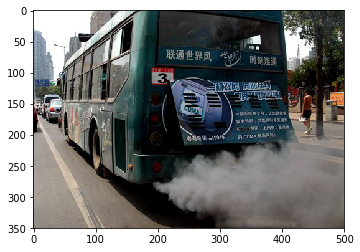

In [21]:
img = plt.imread(test_img_paths[4])
plt.imshow(img)

In [22]:
window_list = slide_window(img)
len(window_list)

126

In [23]:
smoke_regions = []
for window in window_list:
    test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
    prediction = get_prediction(test_img, model)
    if prediction == 1:
        smoke_regions.append(window)

In [24]:
smoke_regions

[((320, 192), (384, 256)),
 ((352, 192), (416, 256)),
 ((192, 224), (256, 288)),
 ((224, 224), (288, 288)),
 ((256, 224), (320, 288)),
 ((288, 224), (352, 288)),
 ((320, 224), (384, 288)),
 ((352, 224), (416, 288)),
 ((384, 224), (448, 288)),
 ((160, 256), (224, 320)),
 ((192, 256), (256, 320)),
 ((224, 256), (288, 320)),
 ((256, 256), (320, 320)),
 ((288, 256), (352, 320)),
 ((320, 256), (384, 320)),
 ((352, 256), (416, 320)),
 ((384, 256), (448, 320))]

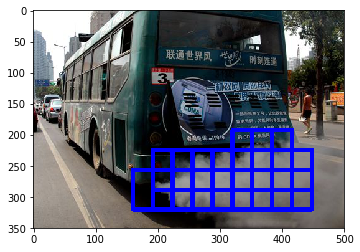

In [25]:
plt.imshow(draw_boxes(img, smoke_regions))

### Get all the test images

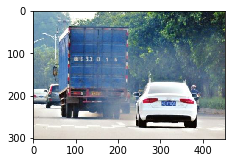

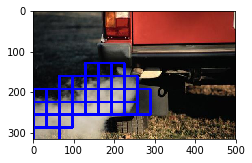

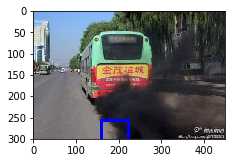

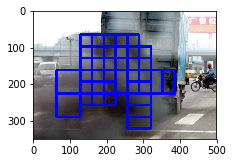

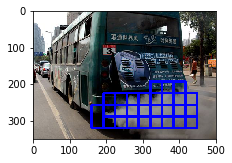

In [26]:
for index, img_path in enumerate(test_img_paths, 1):
    img = plt.imread(img_path)
    smoke_img = detect_smoke(img, model)
    plt.figure(figsize=(16,8))
    plt.subplot(3,2,index)
    plt.imshow(smoke_img)